# Exploration10 - 인공지능으로 세상에 없던 새로운 패션 만들기

DCGAN을 이용하여 CIFAR-10 데이터를 생성하는 모델을 만들어보자.

---

### 루브릭 평가 기준

1. GAN의 두 모델 구조를 통한 이미지 생성 - 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였나
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습 진행 입증 - gif를 통해 생성 이미지 품질이 서서히 향상되는 것과 fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였나
3. 추가적인 GAN 모델 구조 혹은 학습 과정 개선 아이디어 적용 - 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드 및 전처리
  - 데이터 준비
  - 데이터 정규화
    

2) 모델 설계 및 훈련
  - 생성자(Generator) 모델 설계
  - 판별자(Discriminator) 모델 설계
  - 손실함수와 최적화함수
  - 훈련 과정 설계
  - 모델 학습


3) 모델 개선
  - 학습률 조정
  - 학습률 조정 + LeakyReLU 조정
  - 학습률 조정 + 레이어 추가
    
4) 회고

## 필요 모듈 import

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams

## 1. 데이터 로드 및 전처리

### - 데이터 준비
CIFAR-10은 32X32 크기의 train data 50000장, test data 10000장 이미지로 이루어진 데이터셋이다.  
10개의 클래스로 분류되며 그 항목은 아래와 같다.  

|Label|	Description|
|:---:|:---:|
|0|airplane|
|1|automobile|
|2|bird|
|3|cat|
|4|deer|
|5|dog|
|6|frog|
|7|horse|
|8|ship|
|9|truck|

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

불러온 데이터를 무작위로 10장만 확인해보자.

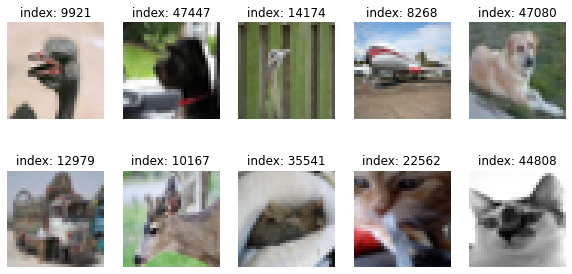

In [3]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
    
plt.show()

### - 데이터 정규화
0\~255 사이의 픽셀값을 -1\~1로 정규화시켜 사용한다.


In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
train_x = train_x / 127.5 - 1# 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


미니 배치 학습을 하기 위한 배치 사이즈와 데이터를 전체적으로 섞을 수 있도록 버퍼 사이즈를 지정한다. 

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

tensorflow의 Dataset을 이용하여 데이터를 섞어준다.  

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. 모델 설계 및 훈련

### - 생성자(Generator) 설계

생성자는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지를 생성한다.  
CIFAR-10 데이터와 동일하게 (32, 32, 3) shape의 이미지를 생성할 수 있도록 한다.  

In [8]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만든 후 노이즈로부터 이미지를 생성할 수 있도록 생성자에 넣어준다.

In [10]:
# 노이즈 생성
noise = tf.random.normal([1, 100])

# 노이즈로부터 이미지 생성
generated_image = generator(noise, training=False)   # 학습중이 아니므로 training=False
generated_image.shape

TensorShape([1, 32, 32, 3])

생성된 이미지를 시각화해보자.  
이때, matplotlib 라이브러리는 2차원의 이미지만 표시할 수 있으므로 (32, 32) shape만 꺼내서 사용한다.

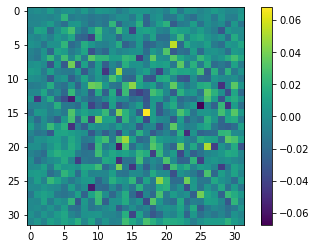

In [11]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### - 판별자(Discriminator) 설계

판별자는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 real인지 fake인지 판단하여 실숫값으로 출력한다.  
따라서 출력은 단 하나의 숫자이다.

In [12]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

노이즈로부터 생성자를 거쳐 생성된 이미지를 판별자에 넣어주면 (1, 1)의 텐서가 출력된다.

In [14]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00197436]], dtype=float32)>

### - 손실함수와 최적화함수

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.  
특히 판별자는 이미지가 진짜인지 가짜인지 2개의 클래스로 분류하므로 이진 교차 엔트로피(binary cross entropy)를 사용한다.  

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

생성자와 판별자의 정확도를 따로 계산해서 비교하는 것은 GAN의 학습에서 매우 유용하다.  
real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다.

In [18]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

최적화 함수로는 생성자와 판별자 모델 둘 다 Adam을 사용한다.  
다만, 생성자와 판별자는 각각 학습을 하는 개별 네트워크이므로 최적화 함수를 따로 정의해야 한다.

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### - 훈련 과정 설계

훈련 과정 중 샘플을 확인할 수 있도록 16개의 고정된 seed 노이즈를 만들어 둔다.

In [20]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

하나의 미니 배치 당 진행할 내용에 대한 함수이다.   
 
*  @tf.function 는 무엇일까?  
  학습 시킬 훈련 함수 위에 사용하는 데코레이터이다.  
  이는 학습 과정 중 직접 session을 열고 닫는 등의 번거로운 과정을 내부적으로 처리해준다.


In [21]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수이다.  
앞선 과정에서 만들어둔 16개의 고정된 노이즈를 사용한다.

In [22]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    
    np_predictions = predictions.numpy()
    np_predictions = (np_predictions + 1) * 127.5 # 정규화 했던 것을 되돌리기
    np_predictions = np_predictions.astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(np_predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np_predictions[i])
        plt.axis('off')
   
    plt.savefig('./generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))

    plt.show()

학습 결과에 대한 loss와 accuracy 그래프를 그리는 함수이다.

In [23]:
rcParams['figure.figsize'] = 15, 15    # matlab 차트의 기본 크기를 15,15로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['real_accuracy'])  
    plt.plot(history['fake_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['real_accuracy', 'fake_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('./training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

정기적으로 모델을 저장하기 위해 checkpoint를 사용한다.  
checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장한다.  

In [24]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### - 모델 학습

In [25]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

5에폭마다 모델을 저장하고, 총 700 에폭 학습을 진행한다.

In [26]:
save_every = 5
EPOCHS = 700

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

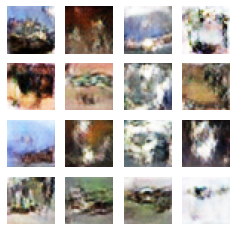

Time for training : 3869 sec


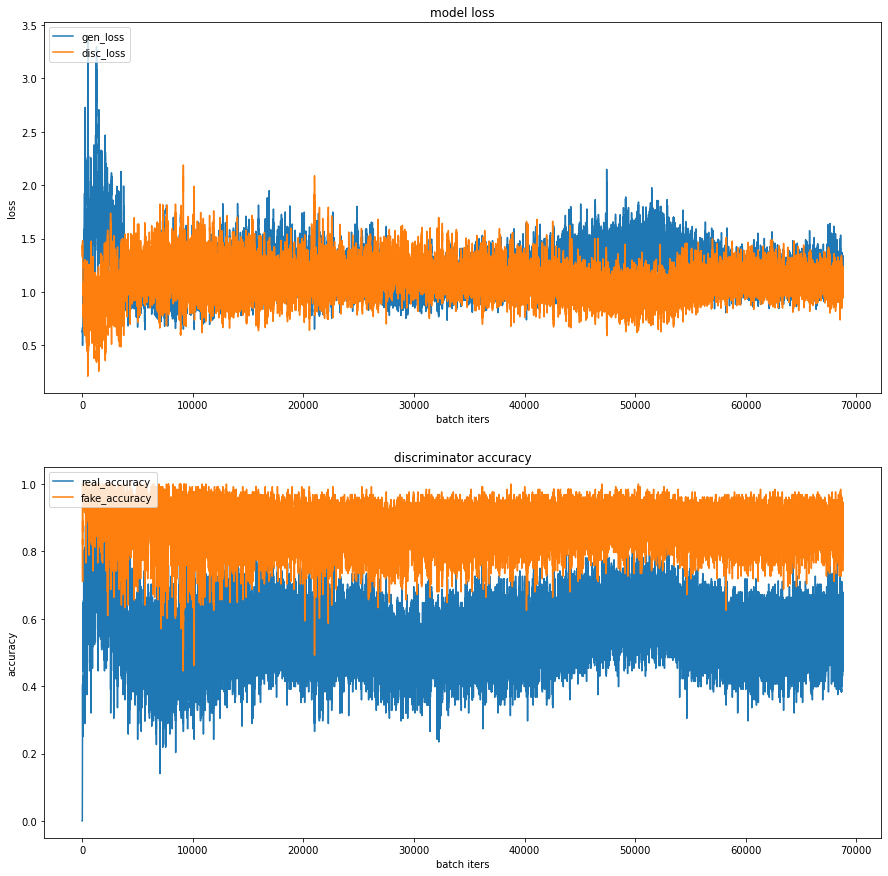

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

커널이 죽으면서 학습이 반쯤 진행된 시점에 중단되었다.  
파이썬 파일을 이용하여 Cloud Shell에서 처음부터 학습을 다시 진행하였다.  
학습에 사용한 파이썬 파일은 [여기](https://github.com/chaen805/AIFFEL_Exploration/blob/master/EX10/train%20code/train_orig.py)에서 확인 가능하다.  
이후 과정은 모두 이와 같은 방식으로 진행된다.

In [ ]:
anim_file = './cifar_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

#### 결과 확인

학습 진행 후 저장된 샘플들과 그래프를 확인해보자.

- generated sample
![sample](./sample_gif/cifar_dcgan.gif)

- training history
![history](./train_history/train_history_orig.png)

fake accuracy가 0.5 근처에 도달하지도 못하고 그러한 추세도 보이지 않는다.  
판별자를 속이기엔 많이 부족해보인다.  
모델 개선이 필요할 것 같다.  
그래도 모델이 생성하는 이미지를 확인해보자!

In [27]:
# 저장된 체크포인트 불러오기
checkpoint_dir = './training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

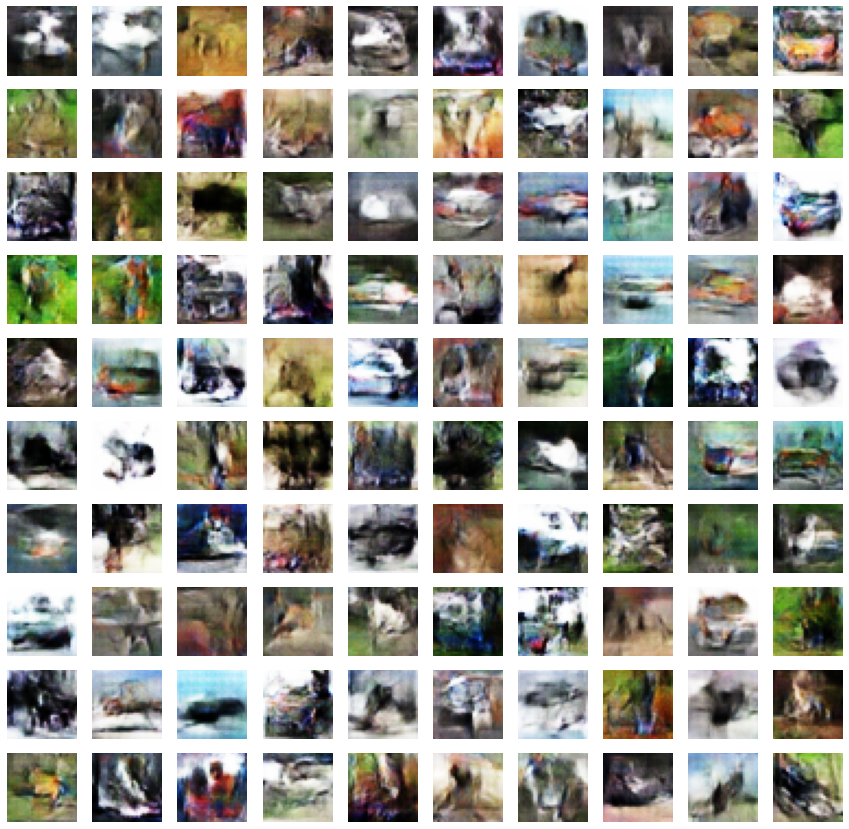

In [28]:
# 모델이 생성하는 이미지 확인
for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False) # 이미지 생성
    
    np_generated = generated_image.numpy()
    np_generated = (np_generated + 1) * 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    
    plt.imshow(np_generated[0])
    plt.axis('off')

plt.show()

정확하게 무엇이라고 할 수는 없지만 어쩐지 조금만 노력하면 동물이 될 수 있을 것만 같은 이미지들이다.  
모델을 개선하여 조금 더 확실한 이미지를 얻어보겠다.

## 3. 모델 개선

### - 학습률 조정

[조언](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)에 따라 optimizer인 Adam을 정의할 때 learning rate와 momentum(beta1) 값을 조정해주었다.  

학습을 진행한 코드는 [여기](https://github.com/chaen805/AIFFEL_Exploration/blob/master/EX10/train%20code/train_adam.py)에서 확인 가능하다.

In [29]:
generator_optimizer2 = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-4, 0.5)

- generated sample
![sample1](./sample_gif/cifar_dcgan_ver1.gif)

- training history

![history1](./train_history/train_history_ver1.png)

학습 후반부로 갈 수록 fake accuracy가 0.5 아래로 내려가는 배치가 많이 보인다.  
기존의 모델보다는 수치상으로 더 좋아보인다.  
모델이 생성하는 이미지를 직접 확인해보자!

- 저장된 체크포인트 불러오기

In [30]:
checkpoint2 = tf.train.Checkpoint(generator_optimizer=generator_optimizer2,
                                 discriminator_optimizer=discriminator_optimizer2,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
# 저장된 체크포인트 불러오기
checkpoint_dir = os.getenv('HOME')+'/aiffel/exploration/ex10_dcgan_newimage/ver1/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint2.restore(latest)

generator2 = checkpoint2.generator
discriminator2 = checkpoint2.discriminator

- 생성 이미지 확인

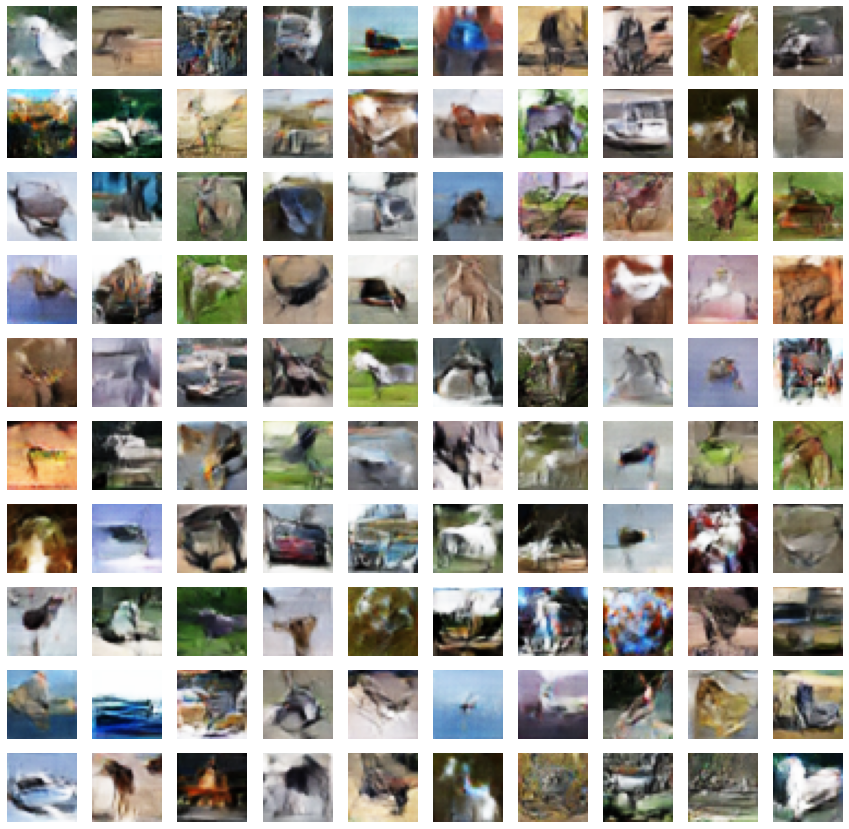

In [32]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator2(noise, training=False)
    
    np_generated = generated_image.numpy()
    np_generated = (np_generated + 1) * 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    
    plt.imshow(np_generated[0])
    plt.axis('off')

plt.show()

최초의 모델보다는 조금 더 선명한 이미지를 얻어냈다.  
(2, 8) 위치에 있는 이미지는 배라고 주장(?)할 수도 있을 것 같다.  
(6, 3) 위치의 이미지는 말이라고 주장해보겠다.  
그 외 몇몇 이미지들도 편견을 버리고 보면 CIFAR-10 클래스에 속하는 것 처럼 보일 수도 있겠다.  
에폭을 늘려 학습을 더 해주면 괜찮은 결과를 얻을 수 있을 것 같다.

### - 학습률 조정 + LeakyReLU 조정

위의 과정에서 학습률 조정이 효과가 있는 것을 확인했으니 이는 그대로 유지하고 LeakyReLU 함수의 alpha 값을 조정해주었다.  
그동안은 ReLU 함수를 주로 사용했는데, 이론으로만 배웠던 LeakyReLU를 처음 사용해보니 alpha 값에 따른 차이를 실험해보고 싶었다.  
keras의 LeakyReLU는 alpha 기본 0.3으로 되어있는데 이를 0.1로 바꾸어 모델을 만들어보자.  

학습을 진행한 코드는 [여기](https://github.com/chaen805/AIFFEL_Exploration/blob/master/EX10/train%20code/train_leaky.py)에서 확인 가능하다.


* 모델 설계

In [33]:
def make_generator_model_leaky():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [34]:
def make_discriminator_model_leaky():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [35]:
generator3 = make_generator_model_leaky()
discriminator3 = make_discriminator_model_leaky()

- generated sample
![sample2](./sample_gif/cifar_dcgan_ver2.gif)

- training history

![history2](./train_history/train_history_ver2.png)

그래프의 수치로만 봤을 때는 학습률만 조정한 직전의 모델보다 성능이 좋아보이지는 않는다.  
모델을 불러와 직접 이미지를 생성시켜보자.


* 저장된 체크포인트 불러오기

In [36]:
checkpoint3 = tf.train.Checkpoint(generator_optimizer=generator_optimizer2,
                                 discriminator_optimizer=discriminator_optimizer2,
                                 generator=generator3,
                                 discriminator=discriminator3)

In [37]:
# 저장된 체크포인트 불러오기
checkpoint_dir = os.getenv('HOME')+'/aiffel/exploration/ex10_dcgan_newimage/ver2/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint3.restore(latest)

generator3 = checkpoint3.generator
discriminator3 = checkpoint3.discriminator

* 생성 이미지 확인

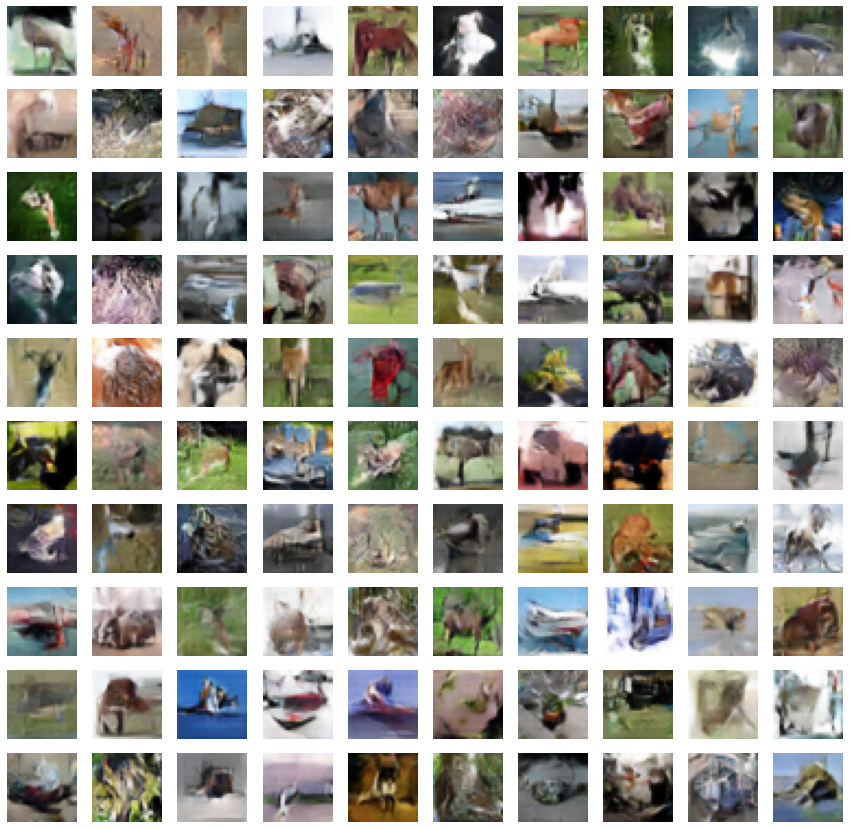

In [38]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator3(noise, training=False)
    
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5
    np_generated = np_generated.astype(int)
    
    plt.imshow(np_generated[0])
    plt.axis('off')

plt.show()

그래프에서 확인했듯 좋은 선택은 아닌듯하다.  
이미지가 약간 흐릿한 느낌이 있다.  
이미지의 완성도 또한 부족하다.  
직전의 모델과는 다르게 마음의 눈으로 봐도 무엇이라 주장하기 힘들다.

### - 학습률 조정 + 레이어 추가

마찬가지로 효과가 있었던 optimizer는 유지하고 생성자와 판별자 모델 모두 레이어를 한 층씩 추가해보자.  
이번 모델은 시간이 부족해 앞선 모델들과는 다르게 500 에폭만 학습을 진행하였다.  

학습을 진행한 코드는 [여기](https://github.com/chaen805/AIFFEL_Exploration/blob/master/EX10/train%20code/train_add_layer.py)에서 확인 가능하다.

* 모델 설계

In [39]:
def make_generator_model_addLayer():

    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [40]:
generator4 = make_generator_model_addLayer()

generator4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 256)         1638400   
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 256)        

In [41]:
def make_discriminator_model_addLayer():

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

In [42]:
discriminator4 = make_discriminator_model_addLayer()

discriminator4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)        

- generated sample
![sample3](./sample_gif/cifar_dcgan_ver3.gif)

- training history

![history3](./train_history/train_history_ver3.png)

그래프 상으로 봤을 때, 레이어를 한 층 더 쌓는 것이 가장 효과적인 것 같다.  
학습 후반부로 갈수록 fack accuracy가 확실하게 0.5를 향하고 있다.  
다른 모델들과 마찬가지로 700 에폭을 학습했으면 더욱 잘 보였을 것으로 예상된다.  
이번 모델이 생성하는 이미지를 확인해보자.


* 저장된 체크포인트 불러오기

In [43]:
checkpoint4 = tf.train.Checkpoint(generator_optimizer=generator_optimizer2,
                                 discriminator_optimizer=discriminator_optimizer2,
                                 generator=generator4,
                                 discriminator=discriminator4)

In [44]:
# 저장된 체크포인트 불러오기
checkpoint_dir = os.getenv('HOME')+'/aiffel/exploration/ex10_dcgan_newimage/ver3/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint4.restore(latest)

generator4 = checkpoint4.generator
discriminator4 = checkpoint4.discriminator

* 생성 이미지 확인

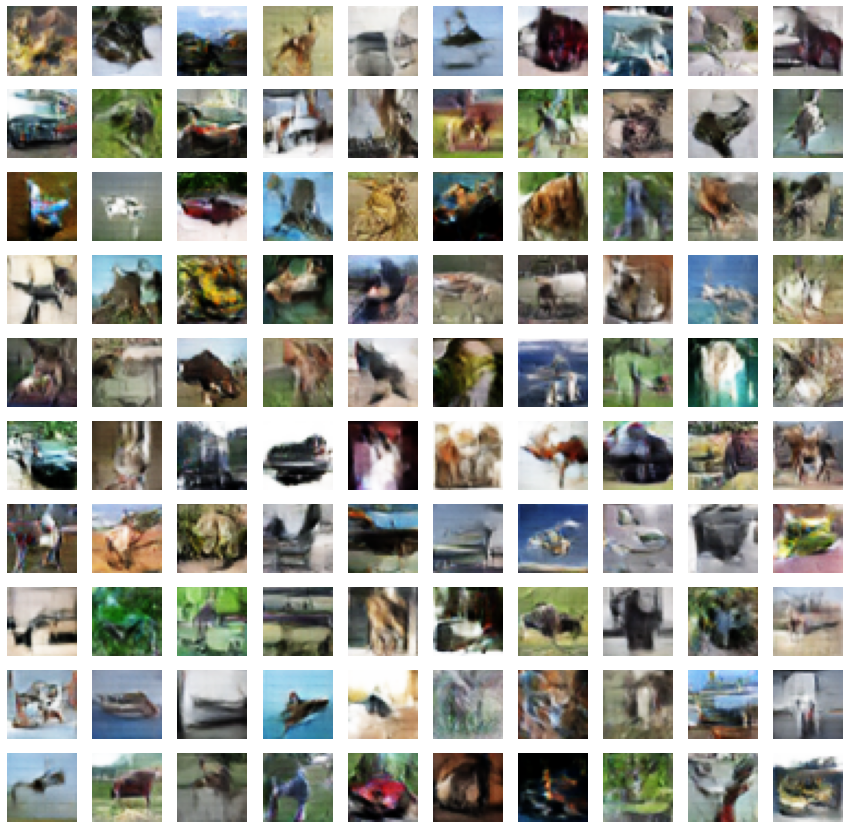

In [45]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator4(noise, training=False)
    
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5
    np_generated = np_generated.astype(int)
    
    plt.imshow(np_generated[0])
    plt.axis('off')

plt.show()

생성된 이미지는 예상과는 다르다.  
몇몇 이미지에 대해서 CIFAR-10의 클래스에 해당하는 이미지라고 주장할 수는 있겠으나,  
다른 모델이 생성한 이미지들 보다 바둑판 무늬가 잘보여 선명한 이미지라는 느낌이 들지 않는다.  
Conv2DTranspose 레이어를 쌓을 때 커널 크기를 고려하지 않은 탓이다.  
이를 고려하여 모델을 설계하고 학습을 진행하면 더 좋은 결과를 기대할 수 있을 것 같다.

## 4. 회고

#### - 커널.. 죽어버리다!!
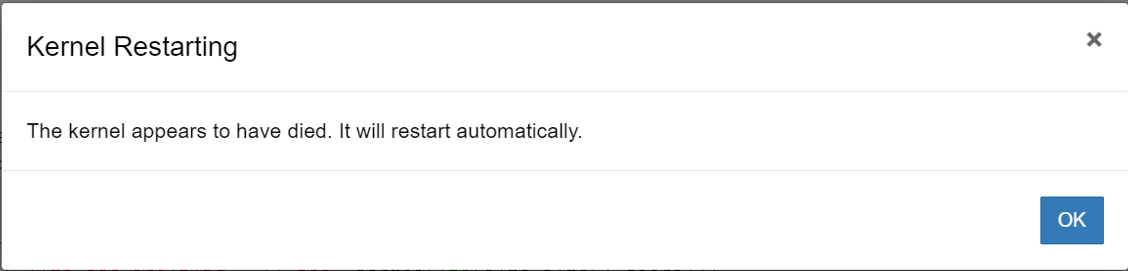
주피터 노트북에서 학습 중 내 눈앞에서 커널이 끊기며 학습이 중단되었다. =͟͟͞͞(꒪ᗜ꒪ ‧̣̥̇)  
반쯤 학습이 진행되었을 때 이런 현상이 발생하니 주피터 노트북에서 학습을 진행하려는 생각이 싹 사라졌다.  
그래서 파이썬 파일을 만들어 터미널에서 실행했다.  
내 눈에는 안보여도 잘 돌아가고 있겠지.. 하는 마음으로 했다.  
중간 결과를 제출 노트북에 다 담을 수 없다는 건 아쉽지만 그래도 같은 고통을 더 겪을 수는 없었다.  


#### - 모델을 불러오기 위한 수많은 시도

편의상 개선된 모델을 순서대로 모델 1, 2, 3이라 칭하겠다.


모델 2를 학습시키고 노트북으로 불러올 때, LeakyReLU의 alpha 값을 바꾼 걸 생각못하고 기존의 생성자 모델을 그대로 사용하였다.   
생성된 이미지는 전부 형태를 알아볼 수 없을만큼 까맣게 출력되었다.   
처음에는 원인을 못찾고 이게 수치상으로만 좋아보이고 사실은 엉망인 모델인건가..? 라는 생각을 했다.  


그 이후 모델 3에 대한 체크포인트를 불러오려니 shape 관련 오류가 발생하였다.  
이때서야 체크포인트가 학습된 모델에 맞게 생성자와 판별자를 다시 선언해주어야 한다는 것을 깨달았다.  

다시 모델 2로 돌아가 생성자와 판별자 모델을 새로 선언하고 체크포인트를 불러와 이미지를 생성해보니 제대로된 이미지가 출력되었다.  
역시 실패하면서 배우는 것이 많은 것 같다!


#### - fake와 real의 자리

기존의 노드에서 학습한 코드는 accuracy 그래프를 그릴 때 fake를 먼저 그리고 그 위에 real을 그려 fake accuracy를 가려버렸다.  
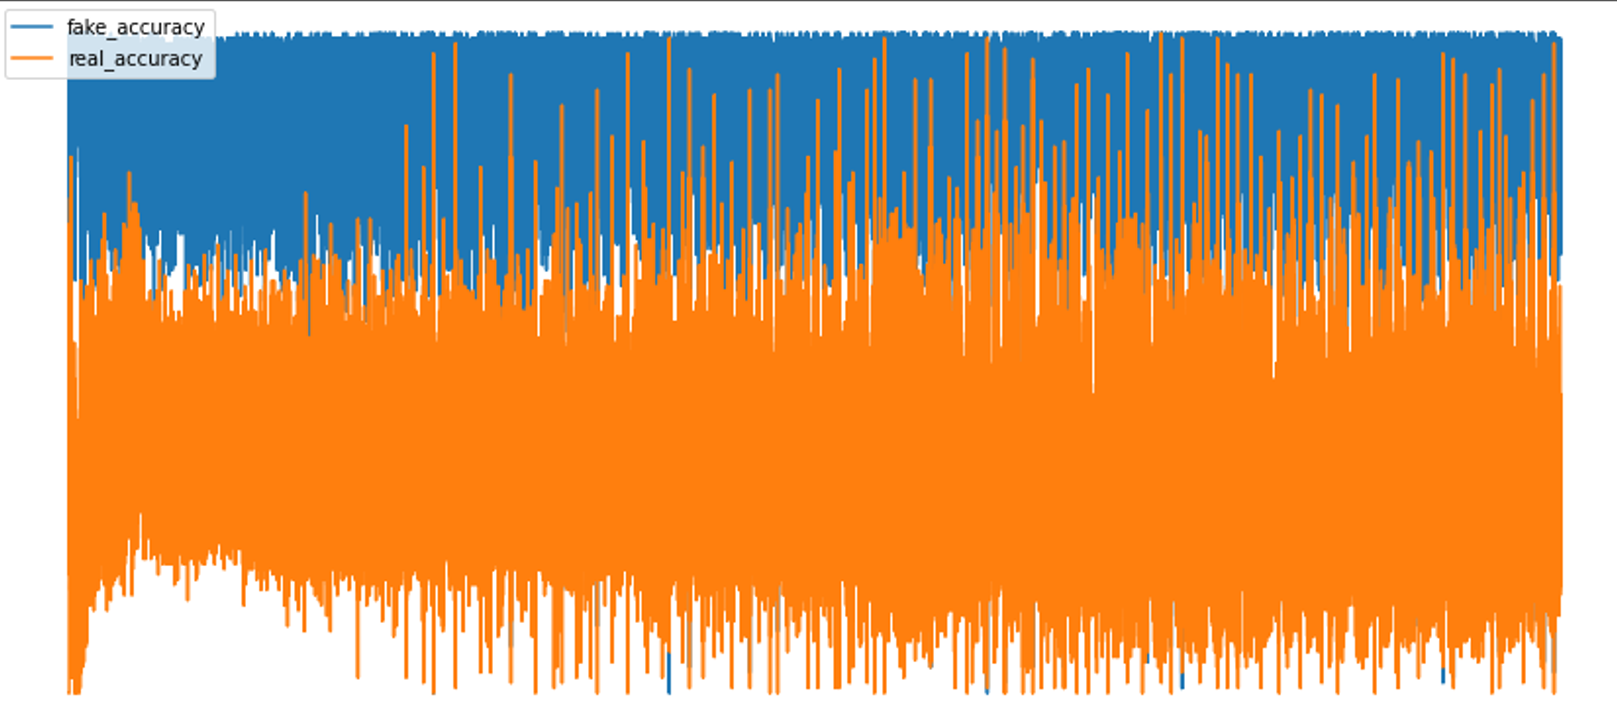
일부 배치에 대해서 fake accuracy가 0.5 아래로 내려온게 슬쩍 보이는데 확실하게 보이지 않으니 답답했다.  
그래서 이 둘을 그리는 순서를 바꾸어 주었더니 마음에 드는 그래프가 나왔다.  
루브릭 기준에 fake accuracy가 0.5를 향하는지 보이는 것이 있기 때문에 이를 반드시 시각화 하고 싶었다.   
역시 데이터든 결과든 설득력을 얻기 위해서 시각화는 중요한 것 같다.